In [1]:
#import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn import svm 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, normalize


from IPython.core.magic import register_cell_magic


# commands to skips cells // %%skip
@register_cell_magic
def skip(line, cell):
    return

## Load data from csv files

In [2]:
from sklearn.preprocessing import StandardScaler, normalize

df = pd.read_csv('data/train_tfidf_features.csv')

X, y = df.drop(columns=["id","label"]),df["label"]

#split df into train,test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val ,y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

test_df = pd.read_csv('data/test_tfidf_features.csv')
test_data,id = test_df.drop(columns=["id"]),test_df["id"]



# Task 3

# Feature Engineerings

## Feature reductions Algorithm

Decide which featre reduction to use:
- PCA
- LSA
- Chi^2 test 

Reasin for picking the 3 models:
- PCA: Standard 
- LSA: Good for preserving the semantic meaning in text data
- Chi2:

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

#Test to run: reduce features to k=2000 and compare score between each baseline model 

# Define classifier
baseline_model = LogisticRegression(max_iter=1000, random_state=678)

# 1. Baseline: No feature reduction
scores_baseline = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='f1')

# 2. Feature Selection: Select top k=2000 features using Chi^2 test
selector = SelectKBest(chi2, k=2000)
X_selected = selector.fit_transform(X_train, y_train)
scores_selection = cross_val_score(baseline_model, X_selected, y_train, cv=5, scoring='f1')

# 3. Feature reduction: PCA reduce to 2000 feature
pca = PCA(n_components=2000, random_state=42)
X_pca = pca.fit_transform(X_train)
scores_pca = cross_val_score(baseline_model, X_pca, y_train, cv=5, scoring='f1')


# 3.  Feature reduction: LSA reduce to 2000 feature
lsa = TruncatedSVD(n_components=2000, random_state=42)
X_LSA= lsa.fit_transform(X_train)
scores_lsa = cross_val_score(baseline_model, X_LSA, y_train, cv=5, scoring='f1')


# Print results
print("Accuracy with all features:     %.4f ± %.4f" % (np.mean(scores_baseline), np.std(scores_baseline)))
print("Accuracy with Chi2:           %.4f ± %.4f" % (np.mean(scores_selection), np.std(scores_selection)))
print("Accuracy with PCA:               %.4f ± %.4f" % (np.mean(scores_pca), np.std(scores_pca)))
print("Accuracy with LSA:               %.4f ± %.4f" % (np.mean(scores_lsa), np.std(scores_lsa)))





Accuracy with all features:     0.5247 ± 0.0205
Accuracy with Chi2: 0.5636 ± 0.0122
Accuracy with PCA:               0.5254 ± 0.0151
Accuracy with LSA:               0.5250 ± 0.0174


### Winner: Chi2

## Now to decide on the value of k that reduce the noise of excess feature and retain the most info

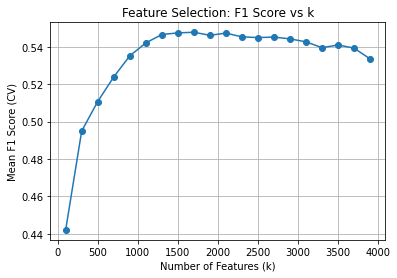

Best k: 1700


In [11]:


k_values = range(100, 4001, 200)  # Try k from 100 to 4000 in steps of 200
mean_scores = []

for k in k_values:
    selector = SelectKBest(chi2, k=k)
    X_selected = selector.fit_transform(X_train, y_train)
    scores = cross_val_score(
        LogisticRegression(max_iter=1000, random_state=42), # same baseline model as before
        X_selected, y_train, cv=3, scoring='f1'
    )
    mean_scores.append(scores.mean())

plt.plot(k_values, mean_scores, marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean F1 Score (CV)')
plt.title('Feature Selection: F1 Score vs k')
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(mean_scores)]
print("Best k:", best_k)

## The best k seems to be 1700, however we will be using 1400 as the values plaute after k>1500

### Reducing the data and normalizing the output, so the feature scales consistent, improving the validity of the Chi-Square test. Then splitting the data into train and test sets  
 

In [12]:

selector = SelectKBest(chi2, k=1400)
X_selected = selector.fit_transform(X, y)
test = selector.transform(test_data)
from sklearn.preprocessing import normalize

# X is your data matrix (samples x features)
X_normalized = normalize(X_selected, norm='l2', axis=1)
Test_data= normalize(test, norm='l2', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3)
X_train, X_val ,y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)




## Class imbalance in data set
There is a noticable class imbalance in the training set, thus we can apply some technique to reduce the effect of it.
One way is to perform Oversampling and Undersampling on the train data set

Below is a test to see which SMOTE method give the best results 

In [ ]:

from imblearn.over_sampling import SVMSMOTE,SMOTE, ADASYN
from collections import Counter

# Generate an imbalanced dataset
# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("SMOTE class distribution:", Counter(y_smote))

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print("ADASYN class distribution:", Counter(y_adasyn))
# Apply SVMSMOTE 
smote_enn = SVMSMOTE(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_resampled))

SMOTE class distribution: Counter({0: 5201, 1: 5201})
ADASYN class distribution: Counter({1: 5526, 0: 5201})
Resampled class distribution: Counter({0: 5201, 1: 5201})


In [ ]:
from sklearn.linear_model import LogisticRegressionCV 

samplers = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "SVMSMOTE": SVMSMOTE(random_state=42)
}
results = {}

for name, sampler in samplers.items():
    # Resample training data
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    # Train SVM
    model = svm.LinearSVC(random_state=5,max_iter=1000)
    model.fit(X_res, y_res)
    
    # Evaluate on validation and test sets
    val_report = classification_report(y_val, model.predict(X_val), output_dict=True)
    test_report = classification_report(y_test, model.predict(X_test), output_dict=True)
    results[name] = {"val": val_report, "test": test_report}

# Print summary
for name in results:
    print(f"\n{name} Validation F1:", results[name]["val"]["weighted avg"]["f1-score"])
    print(f"{name} Test F1:", results[name]["test"]["weighted avg"]["f1-score"])





SMOTE class distribution: Counter({0: 5201, 1: 5201})
ADASYN class distribution: Counter({1: 5526, 0: 5201})
SVMSMOTE class distribution: Counter({0: 5201, 1: 5201})

SMOTE Validation F1: 0.7348415592105804
SMOTE Test F1: 0.7357553478753733

ADASYN Validation F1: 0.7300301938577398
ADASYN Test F1: 0.7336941448948315

SVMSMOTE Validation F1: 0.7464360189137431
SVMSMOTE Test F1: 0.746148059194778


### ^As shown SVMSMOTE seems to give the best F1 score in a basic test

## However, if we perform the same test on the untouch training data, it seems to  give a better results than applying SVMSMOTE. Thus, we will not be using Oversampling train data in our models
*Note: we tried evaluating with other models other than SVC (e.g. Random forest,Logistic Regression, etc..), they all return the same result. Not using SMOTE is better.


** Although in some case SVMSMOTE is similar to a untouch data set

In [15]:
model.fit(X_train, y_train)
val_report = classification_report(y_val, model.predict(X_val), output_dict=True)
test_report = classification_report(y_test, model.predict(X_test), output_dict=True)
results["Normal"] = {"val": val_report, "test": test_report}
print(f"\nNormal Validation F1:", results["Normal"]["val"]["weighted avg"]["f1-score"])
print(f"Normal Test F1:", results["Normal"]["test"]["weighted avg"]["f1-score"])


Normal Validation F1: 0.7491475641288506
Normal Test F1: 0.7498928872376787


# Now its time to train some models 

### Function for lift & gain curve as well as ROC curve for model testing

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
def plot_lift_curve(y_true, y_proba, step=0.01):
    df = pd.DataFrame({'true': y_true, 'proba': y_proba})
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    baseline = df['true'].mean()
    n = len(df)
    x_pts = np.arange(step, 1+step, step)
    y_lift = []
    for x in x_pts:
        n_top = int(n * x)
        if n_top == 0: continue
        top_rate = df['true'].iloc[:n_top].mean()
        y_lift.append(top_rate / baseline)
    plt.plot(x_pts, y_lift, label='Model Lift')
    plt.axhline(1, color='red', linestyle='--', label='Baseline')
    plt.xlabel('Fraction of Sample')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend()
    plt.show()

def plot_gain_chart(y_true, y_proba, step=0.01):
    # Combine true labels and predicted probabilities into a DataFrame
    df = pd.DataFrame({'true': y_true, 'proba': y_proba})
    # Sort by predicted probability descending
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)

    total_positives = df['true'].sum()
    n = len(df)
    x_points = np.arange(step, 1+step, step)
    gains = []

    for x in x_points:
        cutoff = int(n * x)
        if cutoff == 0:
            continue
        top_positives = df['true'].iloc[:cutoff].sum()
        gain_percent = (top_positives / total_positives) * 100
        gains.append(gain_percent)

    plt.figure(figsize=(10,6))
    plt.plot(x_points * 100, gains, label='Model Gain')
    plt.plot([0, 100], [0, 100], linestyle='--', color='red', label='Random')
    plt.xlabel('Percentage of Sample (%)')
    plt.ylabel('Cumulative Gain (%)')
    plt.title('Gain Chart')
    plt.legend()
    plt.grid(True)
    plt.show()


def ROC_curve(y_test, y_pred_proba):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC AUC: {auc_score:.3f}')

    # Find optimal threshold (Youden's J statistic)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    print(f'Optimal Threshold: {optimal_threshold:.3f}')

    # Plot ROC curve with optimal threshold point
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Let's start with a basic SVM model as a baseline comparison

The SVM model we will be using is sklearn LinearSVC, due to it being optimise for large data set such as this.
The model is quite fast for a SVM model

In [ ]:
#BASE MODEL
from sklearn import svm 
SVM_L = svm.LinearSVC(random_state=5,)
SVM_L.fit(X_resampled, y_resampled)

print(classification_report(y_val,SVM_L.predict(X_val)))
print(classification_report(y_test,SVM_L.predict(X_test)))



              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2236
           1       0.65      0.70      0.68      1373

    accuracy                           0.74      3609
   macro avg       0.73      0.74      0.73      3609
weighted avg       0.75      0.74      0.75      3609

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      3196
           1       0.65      0.72      0.68      1960

    accuracy                           0.74      5156
   macro avg       0.73      0.74      0.73      5156
weighted avg       0.75      0.74      0.75      5156



As we can see the model has an avg score of 0.75 on both the test and validation set

## Let's try on another untune model : XGboost Forest

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2236
           1       0.68      0.44      0.53      1373

    accuracy                           0.71      3609
   macro avg       0.70      0.66      0.66      3609
weighted avg       0.70      0.71      0.69      3609

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      3196
           1       0.69      0.45      0.54      1960

    accuracy                           0.71      5156
   macro avg       0.70      0.66      0.67      5156
weighted avg       0.71      0.71      0.70      5156

ROC AUC: 0.754
Optimal Threshold: 0.355


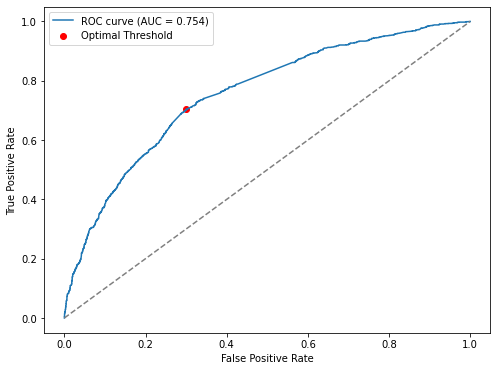

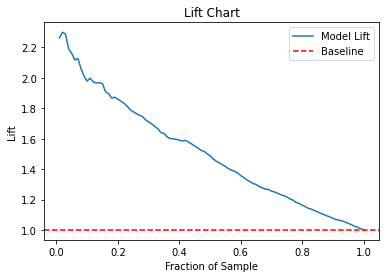

In [24]:

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

print(classification_report(y_val,model.predict(X_val)))
print(classification_report(y_test,model.predict(X_test)))

ROC_curve(y_val,model.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,model.predict_proba(X_val)[:, 1])


## Graph info


ROC AUC ≈ 0.75 → Model is clearly better than random but not perfect separation.

Lift chart → Show the cumulative performance as you include more of the ranked predictions.Initial high lift means the model is effective at prioritizing positives. 


## So given the transform data set we get an averge f1 score of .70 between the two models

### Let's try to improve it by:
- hyperparameter tuning
- ensemble stacking


## First let's decide how many model we want to experiment stack with:

## Base Model:
- XGBoost
- SVM linear
- Logistic Regression
- SVM rbf


In [27]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier



## Let's see how well does a base line stack 

In [28]:



SVM = LinearSVC(random_state=89)
lg_meta = LogisticRegressionCV(random_state=89)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=89)
lg = LogisticRegressionCV(random_state=89)

SVC = SVC(kernel="rbf",random_state=31)

# Stacking ensemble: SVM acts as base model, XGBoost as meta-model
stacking_clf = StackingClassifier(
    estimators=[('xgb',xgb),('SVM Linear',SVM_L),('logistic regression',lg),('SVM rbf',SVC)],
    final_estimator=lg_meta,
    passthrough=False,
    cv=3,

)

# Fit stacking model
stacking_clf.fit(X_train, y_train)

c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:23:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:23:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=3,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('SVM Linear', LinearSVC(random_state=5)),
                               ('logistic regression',
                                LogisticRegressionCV(random_state=89)),
                               ('SVM rbf', SVC(random_state=31))],
                   final_estimator=LogisticRegressionCV(random_state=89))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2236
           1       0.73      0.57      0.64      1373

    accuracy                           0.76      3609
   macro avg       0.75      0.72      0.73      3609
weighted avg       0.75      0.76      0.75      3609

ROC AUC: 0.816
Optimal Threshold: 0.358


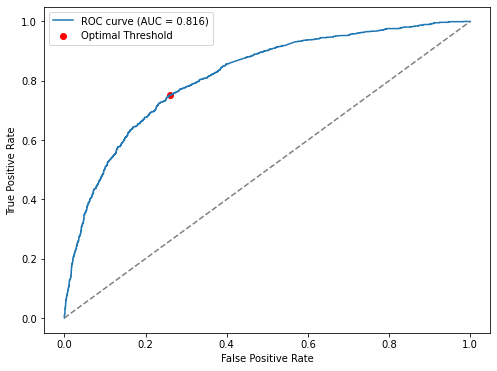

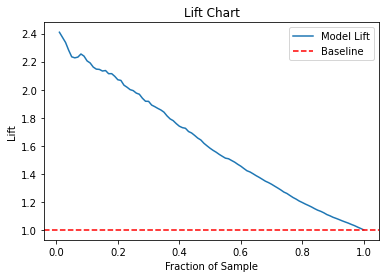

In [31]:

print(classification_report(y_val,stacking_clf.predict(X_val)))
ROC_curve(y_val,stacking_clf.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,stacking_clf.predict_proba(X_val)[:, 1])


## When using stacking ensemble our ROC AUC scored improved significantly to a .81, while our f1 avg score is still in the .72~.74 range
*The low f1 avg score could be attributed an imbalace training data, as the f1 score of class 0 sample are reaching a 0.82.  
While the class 1 sample's f1 score are stuck at .60~ range 


## So let's fine tune our model to account for the imbalance data

## First we can add an additional feature to classify any outlier.


Why?: Adding a feature to explicitly indicate outliers can significantly enhance a model's ability to identify special or unusual data points (e.g. rare class 1 samples )


How?: We will apply DBSCAN clustering to identify data points that are far away from dense area, and hopefully the models could recoginise these sample and account for it,
we will use the distance from a found nearest centroid as a indicator

Side beneifts: DBSCAN can also identify data sample that could be interpented as noise

In [38]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=0.1, min_samples=15)

# Fit DBSCAN to data
dbscan.fit(X_train)

# Get the cluster labels; noise points are labeled as -1
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")



Estimated number of clusters: 11
Estimated number of noise points: 7800


In [134]:
from sklearn.preprocessing import OneHotEncoder

dbscan = DBSCAN(eps=0.1, min_samples=15)

# Fit DBSCAN to data
dbscan.fit(X_normalized)

labels = dbscan.labels_
cluster_labels = dbscan.fit_predict(X_normalized)  

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

# 2. Encode cluster labels for ML model input
cluster_labels = cluster_labels.reshape(-1, 1)  # reshape for encoder


# 3. Compute distance to cluster centroids
def compute_distances(X, labels):
    distances = np.zeros(X.shape[0])
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:
            # For noise, assign a distance value (e.g., large number)
            distances[labels == label] = np.max(np.linalg.norm(X, axis=1))
        else:
            # Compute centroid of cluster
            cluster_points = X[labels == label]
            centroid = cluster_points.mean(axis=0)
            # Calculate distance from points in cluster to centroid
            distances[labels == label] = np.linalg.norm(X[labels == label] - centroid, axis=1)
    return distances.reshape(-1, 1)

distance_feature = compute_distances(X_normalized, cluster_labels.flatten())

# 4. Combine original features with new cluster features
X_enhanced = np.hstack((X_normalized, distance_feature))


print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")



Estimated number of clusters: 30
Estimated number of noise points: 15525


### Perform the same operation on the test.csv 

In [40]:

# Fit DBSCAN to data
dbscan.fit(Test_data)

labels = dbscan.labels_
cluster_labels = dbscan.fit_predict(Test_data)  

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

# 2. Encode cluster labels for ML model input
cluster_labels = cluster_labels.reshape(-1, 1)  # reshape for encoder



distance_feature = compute_distances(Test_data, cluster_labels.flatten())

test_enchanced = np.hstack((Test_data, distance_feature))

### Resplit the data set
The last feature engineering

In [41]:

X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.3)
X_train, X_val ,y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)


### Let's test the new data set

c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:03:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.763
Optimal Threshold: 0.344


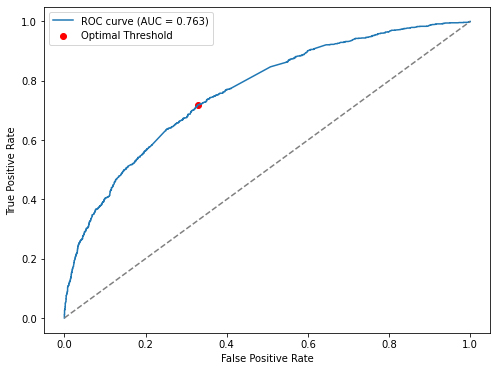

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2262
           1       0.69      0.44      0.54      1347

    accuracy                           0.72      3609
   macro avg       0.71      0.66      0.67      3609
weighted avg       0.71      0.72      0.70      3609



In [55]:
    
# Compare with XGBoost
XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=89)
XGB.fit(X_train, y_train)

# Predict probabilities on test set for positive class
y_pred_proba = XGB.predict_proba(X_val)[:, 1]



ROC_curve(y_val, y_pred_proba)
preds = XGB.predict(X_val)
print(classification_report(y_val,preds))


In [ ]:
ans = model.predict(test_enchanced)
final=id.to_frame()
print(final.shape)
final["label"] = ans
final = final.rename(columns={"id":"row ID"})
final.to_csv('outputwe.csv',index=False )

(4296, 1)


## Hypertuning XGB model

Finding the optimal class scale to acount for class imbalance in training data set

c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:52:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:52:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:52:20] WARNI

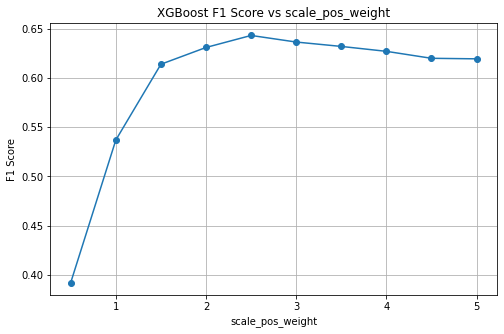

In [ ]:
from sklearn.metrics import f1_score



# Define a range of scale_pos_weight values to evaluate
scale_pos_weights = np.linspace(0.5, 5, 10) 
f1_scores = []

for spw in scale_pos_weights:
    model = XGBClassifier(
        scale_pos_weight=spw,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(scale_pos_weights, f1_scores, marker='o')
plt.title('XGBoost F1 Score vs scale_pos_weight')
plt.xlabel('scale_pos_weight')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'subsample' : hp.uniform('subsample', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        'seed': 0
    }

## 2.5 Scale

In [ ]:

unbiased_xgb = XGBClassifier(
        scale_pos_weight=2.5,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        max_depth = 4
        
    )
unbiased_xgb.fit(X_train, y_train)

print(classification_report(y_test,unbiased_xgb.predict(X_test)))
print(classification_report(y_val,unbiased_xgb.predict(X_val)))
print(classification_report(y_train,unbiased_xgb.predict(X_train)))

c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [01:31:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3233
           1       0.56      0.56      0.56      1923

    accuracy                           0.67      5156
   macro avg       0.65      0.65      0.65      5156
weighted avg       0.67      0.67      0.67      5156

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      2223
           1       0.56      0.53      0.54      1386

    accuracy                           0.66      3609
   macro avg       0.64      0.63      0.63      3609
weighted avg       0.65      0.66      0.66      3609

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5177
           1       0.99      1.00      1.00      3242

    accuracy                           1.00      8419
   macro avg       1.00      1.00      1.00      8419
weighted avg       1.00      1.00      1.00      8419



## Using Randomized Grid Search to find the best hyper-parameter
- Random grid search is faster than normal grid search while producing comparable results, especially with Cross validations used

In [52]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# initial model setup
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    colsample_bytree=0.7,
    subsample=0.7,
    n_estimators=100,
    scale_pos_weight=2,
    learning_rate=0.1,
    max_depth=4
)

# Define parameter distributions for random search
param_distributions = {
    'max_depth': randint(3, 10),            # Tree depth from 3 to 9
    'learning_rate': uniform(0.01, 0.1),    # Learning rate between 0.01 and 0.11
    'n_estimators': randint(50, 300),       # Number of trees from 50 to 299
    'subsample': uniform(0.5, 0.5),         # Subsample ratio from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Colsample ratio from 0.5 to 1.0
    'scale_pos_weight': randint(1, 5)       # Class imbalance weight between 1 and 4
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,              # Number of parameter settings sampled
    scoring='roc_auc',      # Evaluation metric ('auc' for binary classification)
    cv=3,                  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1       # Use all processors
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:00:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.7, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022C3E0A4DC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022C3E0A7760>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022C41AC3760>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022C41AC2EC0>},
                   random_state=42, scoring='roc_auc', verbose=2)

val set classification report
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      2262
           1       0.68      0.43      0.53      1347

    accuracy                           0.71      3609
   macro avg       0.70      0.66      0.66      3609
weighted avg       0.71      0.71      0.69      3609

ROC AUC: 0.760
Optimal Threshold: 0.377


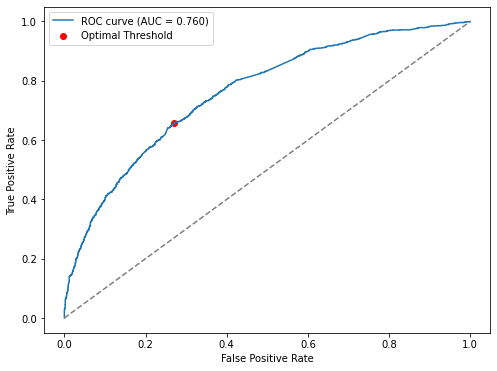

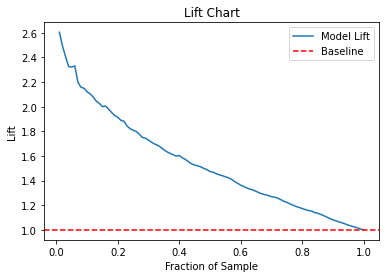

In [53]:

print("val set classification report")

print(classification_report(y_val,random_search.predict(X_val)))
ROC_curve(y_val,random_search.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,random_search.predict_proba(X_val)[:, 1])



## It seems to be doing worst or equal than the baseline set. However, this could mean that this new Model is tune to be more general and less likely to overfit

In [ ]:
print("Training set classification report from the tuned Model")
print(classification_report(y_train,random_search.predict(X_train)))
print("Training set classification report from the Baseline Model")
print(classification_report(y_train,XGB.predict(X_train)))

Training set classification report from the Hypertune Model
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      5218
           1       0.80      0.53      0.63      3201

    accuracy                           0.77      8419
   macro avg       0.78      0.72      0.73      8419
weighted avg       0.77      0.77      0.76      8419

Training set classification report from the Baseline Model
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      5218
           1       0.85      0.57      0.68      3201

    accuracy                           0.80      8419
   macro avg       0.81      0.75      0.77      8419
weighted avg       0.81      0.80      0.79      8419



## For the tuned model; the variance between the Valdation set and the Training set is lower than the untuned model. This shows that the tuned model is more generalized and less overfitting

In [58]:
random_search.best_params_

{'colsample_bytree': 0.9827096756443968,
 'learning_rate': 0.06582934536070977,
 'max_depth': 5,
 'n_estimators': 296,
 'scale_pos_weight': 1,
 'subsample': 0.6394356762960909}

In [59]:
XGB_params = {'colsample_bytree': 0.9827096756443968,
 'learning_rate': 0.06582934536070977,
 'max_depth': 5,
 'n_estimators': 296,
 'scale_pos_weight': 1,
 'subsample': 0.6394356762960909}
Tuned_XGB = XGBClassifier(random_state=42132,**XGB_params)



# SVM tuning

Since a normal SVM rbf model takes a long time to train, we will use bagging/bootstrap method to reduce the training size for the SVM while keeping as much accuracy as we can

Val set classification report
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      2262
           1       0.69      0.39      0.50      1347

    accuracy                           0.71      3609
   macro avg       0.70      0.64      0.64      3609
weighted avg       0.70      0.71      0.68      3609

ROC AUC: 0.769
Optimal Threshold: 0.379


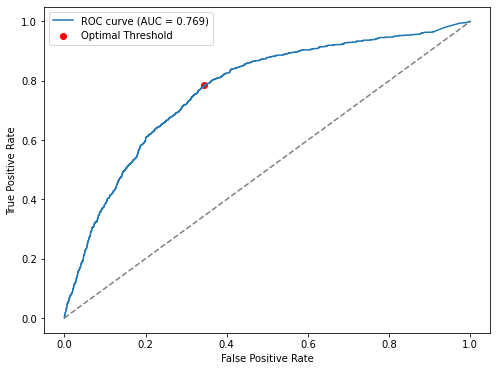

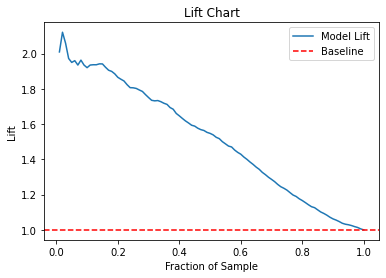

In [76]:
from sklearn.ensemble import BaggingClassifier

from sklearn.svm import SVC



n_estimators = 10
base_svm = SVC(kernel='rbf', probability=True)  # Adjust class weights as needed

# BaggingClassifier will train 10 SVMs each on ~10% of the dataset
bagging_svm_1 = BaggingClassifier(base_svm,
                      n_estimators=n_estimators,
                      max_samples=1.0 / n_estimators, # split sample size by number of SVM models
                      
                      )


bagging_svm_1.fit(X_train, y_train)
print("Val set classification report")
print(classification_report(y_val,bagging_svm_1.predict(X_val)))

ROC_curve(y_val,bagging_svm_1.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,bagging_svm_1.predict_proba(X_val)[:, 1])




In [67]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

base_svc = SVC(kernel='rbf', probability=True)
n_estimators = 10

bagging_svm = BaggingClassifier(
    estimator=base_svc,        # Use "estimator" for modern scikit-learn
    n_estimators=n_estimators,
    max_samples=1.0 / n_estimators,
    random_state=5
)

param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'estimator__tol': [1e-4, 1e-5, 1e-6],
    'n_estimators': [5, 10, 20, 30],
}

grid_search = RandomizedSearchCV(
    bagging_svm,
    param_distributions=param_grid,
    n_iter=5, #lowered iter for speed testing
    cv=2,
    scoring='roc_auc',       # Use 'roc_auc' for binary
    n_jobs=-1,                   # Use all CPUs
    random_state=42
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'n_estimators': 20, 'estimator__tol': 1e-05, 'estimator__gamma': 0.01, 'estimator__C': 0.1}


val set classification report
              precision    recall  f1-score   support

           0       0.68      0.94      0.79      2262
           1       0.72      0.27      0.39      1347

    accuracy                           0.69      3609
   macro avg       0.70      0.60      0.59      3609
weighted avg       0.70      0.69      0.64      3609

ROC AUC: 0.769
Optimal Threshold: 0.379


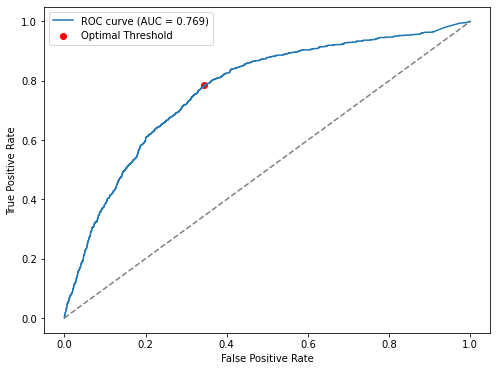

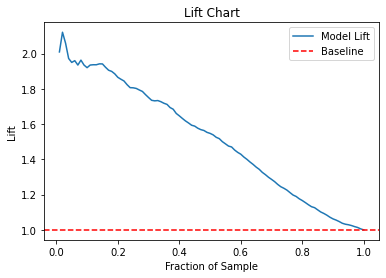

In [138]:
SVC_params =  { 'gamma': 0.01, 'C': 0.1,"tol":1e-05}
tuned_svc = SVC(kernel='rbf', probability=True,**SVC_params)
n_estimators = 20

bagging_svm = BaggingClassifier(
    estimator=base_svc,        # Use "estimator" for modern scikit-learn
    n_estimators=n_estimators,
    max_samples=1.0 / n_estimators,
    random_state=5,
    
)

bagging_svm.fit(X_train,y_train)
print("val set classification report")
print(classification_report(y_val,bagging_svm.predict(X_val)))
ROC_curve(y_val,bagging_svm.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,bagging_svm.predict_proba(X_val)[:, 1])


In [83]:

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l2'],        # Type of regularization
    'loss': ['hinge', 'squared_hinge'],  # Loss function

    'tol': [1e-2, 1e-3, 1e-4],       # Tolerance for stopping
'max_iter': [1000, 2000, 5000],
}

Lsvc = LinearSVC(max_iter=5000, random_state=42)

# RandomizedSearchCV setup
grid_search = RandomizedSearchCV(
    Lsvc,
    param_distributions=param_grid,
    n_iter=15,                  # number of random combinations to test
    cv=3,
    scoring='roc_auc',               # use 'roc_auc' or others if needed
    verbose=2,
    n_jobs=-1,
    random_state=42
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters: {'tol': 0.0001, 'penalty': 'l2', 'max_iter': 5000, 'loss': 'squared_hinge', 'C': 0.1}
Best F1 score: 0.7924994335457534


In [137]:
LinearSVC_parms =  {'tol': 0.0001, 'penalty': 'l2', 'max_iter': 5000, 'loss': 'squared_hinge', 'C': 0.1}
LSVC = LinearSVC(random_state=42,**LinearSVC_parms)
LSVC.fit(X_train,y_train)


print("val set classification report")
print(classification_report(y_val,LSVC.predict(X_val)))
ROC_curve(y_val,LSVC.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,LSVC.predict_proba(X_val)[:, 1])

val set classification report
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2262
           1       0.71      0.55      0.62      1347

    accuracy                           0.75      3609
   macro avg       0.74      0.71      0.72      3609
weighted avg       0.74      0.75      0.74      3609



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

# Logistic Regression

In [ ]:

%%skip # Takes aa very long time 
param_grid = {
    'cv': [3, 5, 7],
    'max_iter': [100, 200, 500,1000],
    'Cs': [5, 10, 20],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
}

lr_cv = LogisticRegressionCV(random_state=42)
grid_search = RandomizedSearchCV(lr_cv, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached w

[CV] END .Cs=20, cv=7, max_iter=100, penalty=l2, solver=saga; total time= 4.7min


c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached w

[CV] END .Cs=20, cv=7, max_iter=100, penalty=l2, solver=saga; total time= 4.7min


c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [79]:
LogisticRegressionCV_pram ={"Cs":20, "cv":7, "max_iter":200, "penalty":"l2", "solver":"saga"}

lr_cv = LogisticRegressionCV(random_state=42,**LogisticRegressionCV_pram)
lr_cv.fit(X_train,y_train)


print("valdation set classification report")
print(classification_report(y_val,lr_cv.predict(X_val)))


ROC_curve(y_val,lr_cv.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,lr_cv.predict_proba(X_val)[:, 1])

c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wei Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import learning_curve

# Example dataset



# Compute learning curve data: train sizes, training scores, validation scores
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lr_cv,
    X=X_train,
    y=y_train,
    cv=7,
    train_sizes=np.linspace(0.1, 1.0, 5),  # Train sizes from 10% to 100%
    scoring='f1',

    shuffle=True,

    random_state=0
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for LogisticRegressionCV')
plt.legend(loc='best')
plt.grid(True)
plt.show()


UsageError: Line magic function `%%skip` not found.


# Final Stack
Time to stack all the tuned model together

Base models :
- Linear SVM
- XGB
- Logisitic Regression (dropped to slow train time)
- SVM with Bagging (dropped due to overfitting)

Meta model:
- Logisitic Regression 

In [98]:


Stack_2 = StackingClassifier(
    estimators=[ 
                ("LSVC",LSVC),
                ("xgb", Tuned_XGB),  # Use unbiased XGB as base model


               ],    
    final_estimator=LogisticRegressionCV(
    cv=3,                    # Number of folds for cross-validation
)
,
    cv=5,                    # Number of folds for cross-validation
    passthrough=False, # prevent training data to be parse to meta model , prevent data leaking
    n_jobs=-1
)
# Fit stacking model
Stack_2.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('LSVC',
                                LinearSVC(C=0.1, max_iter=5000,
                                          random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9827096756443968,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weig...
                                              interaction_constraints=None,
                                              learning_rate=0.06582934536070977,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=296, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegressionCV(cv=3), n_jobs=-1)

### Check for overfitting

valdation set classification report
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2262
           1       0.69      0.60      0.64      1347

    accuracy                           0.75      3609
   macro avg       0.73      0.72      0.72      3609
weighted avg       0.74      0.75      0.74      3609

test set classification report
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      3153
           1       0.69      0.59      0.64      2003

    accuracy                           0.74      5156
   macro avg       0.73      0.71      0.72      5156
weighted avg       0.73      0.74      0.73      5156

train set classification report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5218
           1       0.76      0.66      0.71      3201

    accuracy                           0.79      8419
   macro avg       0.79      

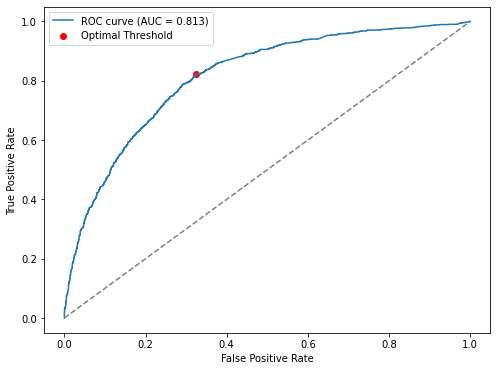

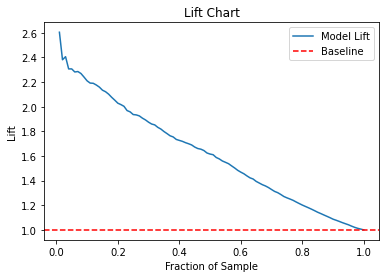

In [99]:

print("valdation set classification report")
print(classification_report(y_val,Stack_2.predict(X_val)))

print("test set classification report")
print(classification_report(y_test,Stack_2.predict(X_test)))


print("train set classification report")
print(classification_report(y_train,Stack_2.predict(X_train)))


ROC_curve(y_val,Stack_2.predict_proba(X_val)[:, 1])
plot_lift_curve(y_val,Stack_2.predict_proba(X_val)[:, 1])

# Final Tweaks

### Changing the threshold for class 1

Changing the threshold for classification could potentially improve model performance, when:
- Class imbalance in training set
- Test data set have lots of outlier/very different data sample 

In this case, both applied, when submitting to kaggle for a score; the score improved whenever I raised the threshold 
This means 2 things:
- The test data set have a lot of class 0 than class 1
- The training data set does not represents the test data very well, lots of outliers




In [ ]:
# Get predicted probabilities for the positive class (assuming binary classification)
probs = Stack_2.predict_proba(X_val)[:, 1]

threshold = 0.47

# Convert probabilities to class labels using the threshold
ans = (probs >= threshold).astype(int)
print("valdation set classification report")
print(classification_report(y_val,ans))



valdation set classification report
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2262
           1       0.66      0.67      0.66      1347

    accuracy                           0.74      3609
   macro avg       0.73      0.73      0.73      3609
weighted avg       0.75      0.74      0.75      3609



In [145]:
# Get predicted probabilities for the positive class 
probs = Stack_2.predict_proba(test_enchanced)[:, 1]


threshold = 0.47

# Convert probabilities to class labels using the threshold
ans = (probs >= threshold).astype(int)

# Prepare the output as before
final = id.to_frame()
final["label"] = ans
final = final.rename(columns={"id":"row ID"})
final.to_csv('task3_latest.csv', index=False)
